In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math
import seaborn as sns; sns.set()

In [2]:
def read_data(data):
    pts = np.genfromtxt(data, delimiter=',')
    try:
        d = len(pts[0]) - 1
        n = len(pts)
        X = pts[:,:-1]
        y = pts[:,-1:]
    except:
        d = len(pts) - 1
        n = 1
        X = pts[:-1].reshape(n,d)
        y = pts[-1].reshape(n,1)
    return(X,y)

In [3]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [4]:
def plot_dbl_graph(xy, xy_p):
    # maybe create a version of this that just takes in the X,y,X_p,y_p values, or a func that reads that also
    X = [a[0] for a in xy]
    y = [a[1] for a in xy]
    X_p = [a[0] for a in xy_p]
    y_p = [a[1] for a in xy_p]
    fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
    ax1.scatter(X,y)
    ax2.scatter(X_p, y_p)
    return fig, (ax1,ax2)

In [5]:
#maybe redo this.
#need to change the min max stuff i think
def single_pt_graph(X, y, X_p, y_p, lines=False):
    # right now only works for single dimension I think? Just need an extra case
    
    # create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 5))
    
    # scatter pts
    ax1.scatter(X, y)
    ax2.scatter(X_p, y_p)
    
    # model
    lm1 = LinearRegression(fit_intercept=False)
    lm1.fit(X,y)
    
    # fit first model
    x_values = 0, X_p.max() + 1
    y = [lm1.coef_[0] * x for x in x_values]
    ax1.plot(x_values, y)
    # set title
    ax1.set_title(str(lm1.coef_[0]))
    
    # 2nd model
    lm2 = LinearRegression(fit_intercept=False)
    lm2.fit(X_p, y_p)
    
    # fit second model
    x_values = 0, X_p.max() + 1
    #y = [lm2.intercept_ + lm2.coef_ * x for x in x_values]
    y = [lm2.coef_[0] * x for x in x_values]
    ax2.set_title(str(lm2.coef_[0]))
    ax2.plot(x_values, y)
    
    return fig, (ax1, ax2)

In [6]:
def extend_ds(X, y, X_p, y_p, pt):
    #fix these
    newx, newy = pt[0], pt[1]
    X = np.append(X, [[newx]], axis=0)
    y = np.append(y, [[newy]], axis=0)
    X_p = np.append(X_p, [[newx]], axis=0)
    y_p = np.append(y_p, [[newy]], axis=0)
    return X,y,X_p,y_p

In [7]:
def extend_ds_single(X, y, pt):
    newx, newy = pt[0], pt[1]
    X = np.append(X, [[newx]], axis=0)
    y = np.append(y, [[newy]], axis=0)
    return X, y

In [8]:
def vary_x(X, y, X_p, y_p, n, pt_0):
    coef = []
    coef_p = []
    x_0, y_0 = pt_0[0], pt_0[1]
    for i in range(n):
        ex_X, ex_y, ex_X_p, ex_y_p = extend_ds(X, y, X_p, y_p, (x_0+i, y_0))
        lm = LinearRegression(fit_intercept=False)
        lm_p = LinearRegression(fit_intercept=False)
        lm.fit(ex_X, ex_y)
        lm_p.fit(ex_X_p, ex_y_p)
        coef.append((x_0+i, lm.coef_[0]))
        coef_p.append((x_0+i, lm_p.coef_[0]))
    return np.asarray(coef), np.asarray(coef_p)

In [9]:
def vary_y(X, y, X_p, y_p, n, pt_0):
    coef = []
    coef_p = []
    x_0, y_0 = pt_0[0], pt_0[1]
    for i in range(n):
        ex_X, ex_y, ex_X_p, ex_y_p = extend_ds(X, y, X_p, y_p, (x_0, y_0+i))
        lm = LinearRegression(fit_intercept=False)
        lm_p = LinearRegression(fit_intercept=False)
        lm.fit(ex_X, ex_y)
        lm_p.fit(ex_X_p, ex_y_p)
        coef.append((y_0+i, lm.coef_[0]))
        coef_p.append((y_0+i, lm_p.coef_[0]))
    return np.asarray(coef), np.asarray(coef_p)

In [10]:
def apply_transform(coef, func):
    # need to make more robust
    n = len(coef)
    transformed_values = np.apply_along_axis(func, 0, coef[:,1])
    values = np.asarray([transformed_values[i][0] for i in range(n)])
    coef = np.append(coef[:,0].reshape(50,1), values.reshape(50,1), axis=1)
    return coef

In [11]:
def fit_coef(coef, coef_p):
    lm = LinearRegression(fit_intercept=False)
    X = np.asarray([a[0] for a in coef])
    y = np.asarray([a[1] for a in coef])
    X_p = np.asarray([a[0] for a in coef_p])
    y_p = np.asarray([a[1] for a in coef_p])
    
    lm.fit(X.reshape(-1,1),y)
    print(lm.coef_, lm.score(X.reshape(-1,1),y))
    
    lm.fit(X_p.reshape(-1,1), y_p)
    print(lm.coef_, lm.score(X.reshape(-1,1),y))

In [12]:
def heat_map(X, y, X_p, y_p):
    fig, (ax1,ax2) = plt.subplots(1, 2, sharex = True, sharey=True, figsize = (15,5))
    
    minX, maxX = int(X_p.min() - X_p.max()), int(X_p.max() + X_p.max())
    
    lm = LinearRegression(fit_intercept=False)
    lm.fit(X, y)
    
    starter = lm.coef_[0]
    change = np.zeros((maxX-minX+1, maxX-minX+1))
    
    lm_p = LinearRegression(fit_intercept=False)
    lm_p.fit(X_p, y_p)
    
    starter_p = lm_p.coef_[0]
    change_p = np.zeros((maxX-minX+1, maxX-minX+1))
    
    for i in range(minX, maxX):
        for j in range(minX, maxX):
            tmp_X, tmp_y, tmp_Xp, tmp_yp = extend_ds(X, y, X_p, y_p, (i,j))
            
            lm.fit(tmp_X, tmp_y)
            change[i,j] = math.fabs(lm.coef_[0] - starter)
            
            lm_p.fit(tmp_Xp, tmp_yp)
            change_p[i,j] = math.fabs(lm_p.coef_[0] - starter_p)

    sns.heatmap(change, ax=ax1)
    sns.heatmap(change_p, ax=ax2)
    ax1.invert_yaxis()
    return fig, (ax1,ax2)

## Learn X from betas

## Motivating ex (pt out far)

In [13]:
X,y = read_data('LinRegLearnX_ds3.csv')
X_p,y_p = read_data('LinRegLearnX_ds4.csv')

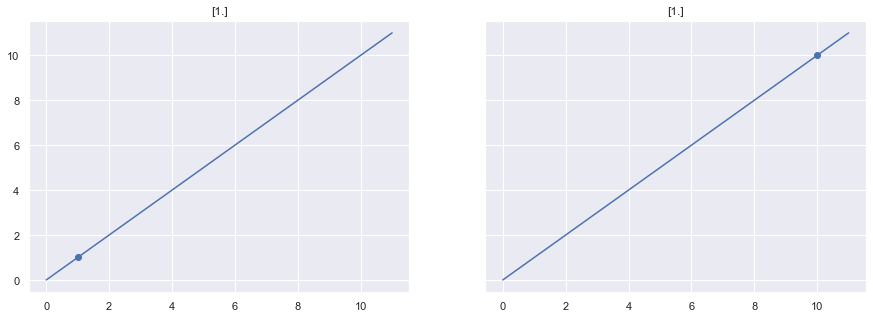

In [14]:
fig, (ax1,ax2) = single_pt_graph(X,y,X_p,y_p)

In [15]:
tmp_X, tmp_y, tmp_Xp, tmp_yp = extend_ds(X, y, X_p, y_p, (21, 22))

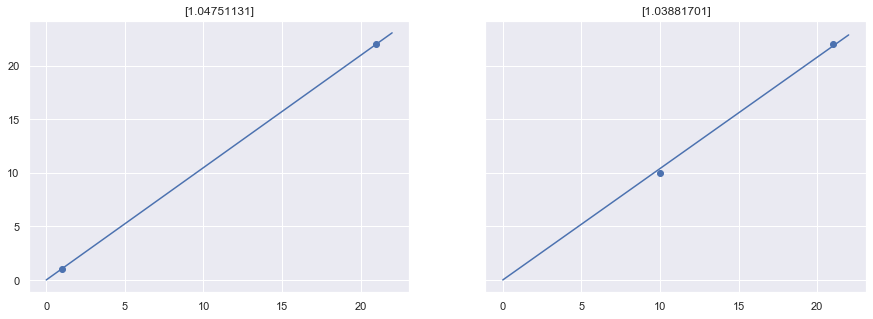

In [16]:
fig, (ax1,ax2) = single_pt_graph(tmp_X, tmp_y, tmp_Xp, tmp_yp)

In [17]:
## what happens when you add a point on one that moves it up and another that moves it down on the second graph
## and then you add second pt that counteracts so each line is the same again

## Vary x

In [18]:
coef, coef_p = vary_x(X, y, X_p, y_p, 50, (21,22))

(<Figure size 1080x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1cfe8390>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1d016f10>))

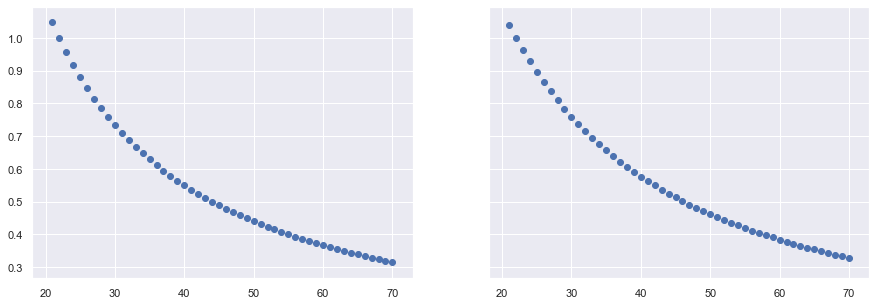

In [19]:
plot_dbl_graph(coef, coef_p)

## Vary y

In [20]:
coef, coef_p = vary_y(X, y, X_p, y_p, 50, (21,22))

(<Figure size 1080x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1d1cecd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1d303cd0>))

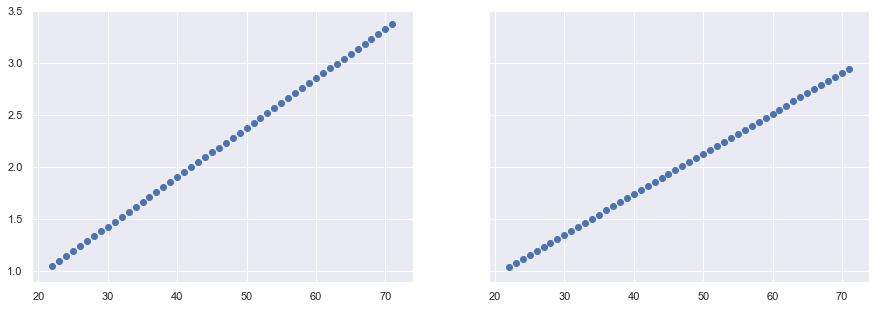

In [21]:
plot_dbl_graph(coef, coef_p)

In [22]:
fit_coef(coef, coef_p)

[[0.04755569]] 0.99999904341966
[[0.0424429]] 0.8681805217482065


In [23]:
## visual for moving x and y

## Motivating ex (pt in middle)

In [24]:
# Can you tell where a new point you add is, relative to existing dataset?
# Always keeping in mind more pts and higher dimensions :(

In [25]:
X,y = read_data('LinRegLearnX_ds1.csv')
X_p,y_p = read_data('LinRegLearnX_ds2.csv')

In [26]:
tmp_X, tmp_y, tmp_Xp, tmp_yp = extend_ds(X, y, X_p, y_p, (15, 16))

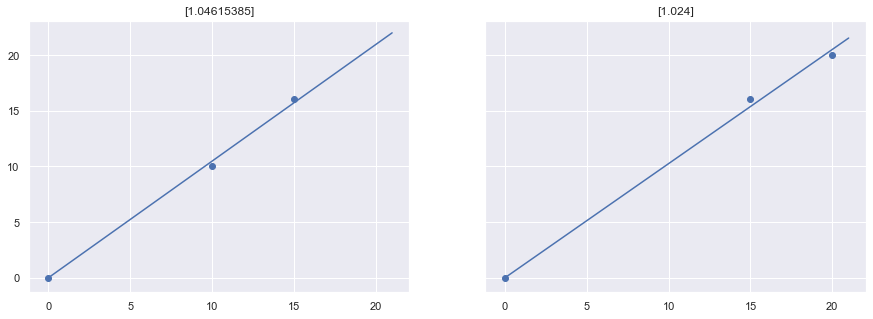

In [27]:
fig, (ax1,ax2) = single_pt_graph(tmp_X, tmp_y, tmp_Xp, tmp_yp)

In [28]:
coef, coef_p = vary_y(X, y, X_p, y_p, 50, (15,16))

(<Figure size 1080x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1d557910>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1cfb0650>))

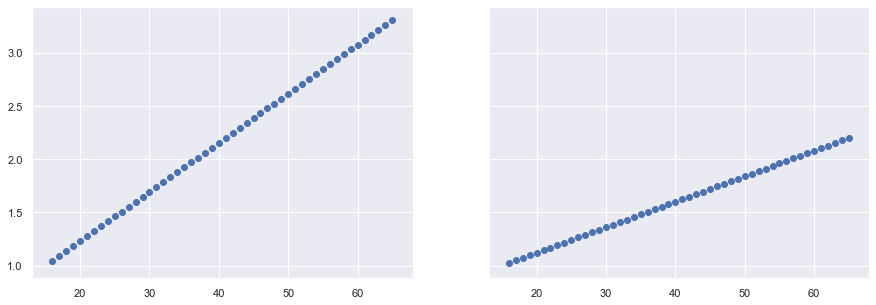

In [29]:
plot_dbl_graph(coef, coef_p)

In [30]:
fit_coef(coef, coef_p)

[[0.05289528]] 0.9759564812310281
[[0.03802218]] 0.054188596625197594


## Heatmap

In [31]:
X,y = read_data('LinRegLearnX_ds1.csv')
X_p,y_p = read_data('LinRegLearnX_ds2.csv')

In [32]:
## need to double check the black lines

(<Figure size 1080x360 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1cea5f10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1cd0d850>))

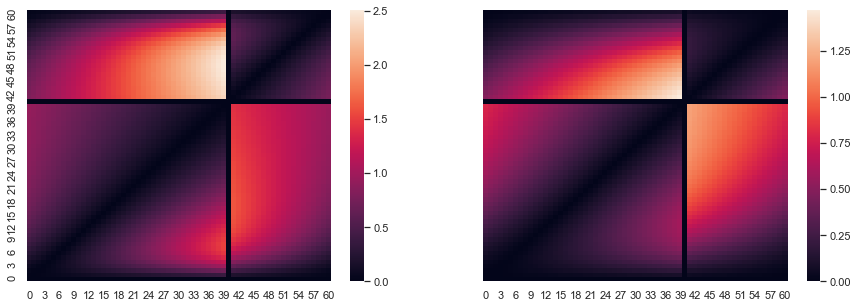

In [33]:
heat_map(X, y, X_p, y_p)

## End of motivating examples -- more focused task

In [34]:
# Given a model, take a random pt and see if new model is uniquely id by pt?
# Given a pt, find a random model, and see if change in model uniquely id old model dataset?

In [35]:
# great! single pt model. should be useful/ fairly intuitive. Also neural net idea for learning update
# might not be a bad idea. Also can redo above with additive. like adding 50 pts to dataset

In [36]:
# think about how 1 pt case carries over to 2 pt case.

In [37]:
X, y = read_data('LinRegLearnX_ds3.csv')
X_p, y_p = read_data('LinRegLearnX_ds4.csv')

(<Figure size 1080x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1d4d0dd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1d7e5c90>))

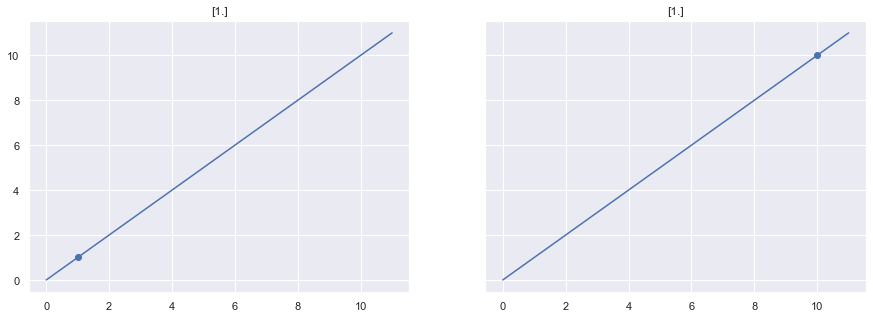

In [38]:
single_pt_graph(X, y, X_p, y_p)

## What happens when we add a pt that is out far?

In [39]:
ex_X, ex_y, ex_X_p, ex_y_p = extend_ds(X, y, X_p, y_p, (12, 13))

### motivating ex

(<Figure size 1080x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1d88b490>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1d8b9bd0>))

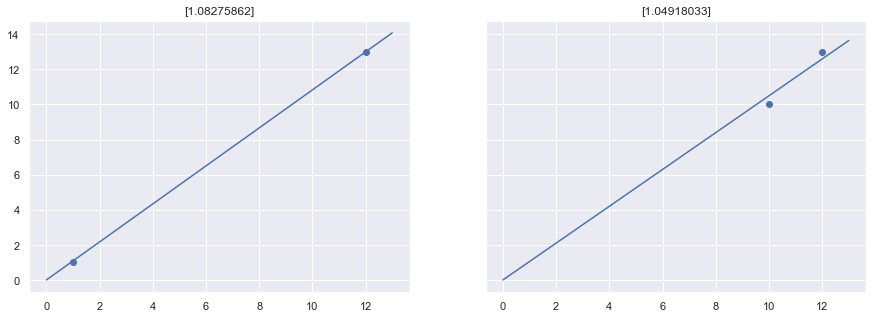

In [40]:
single_pt_graph(ex_X, ex_y, ex_X_p, ex_y_p) #does theta make more sense here?

(<Figure size 1080x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1da2d550>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1dbb6a90>))

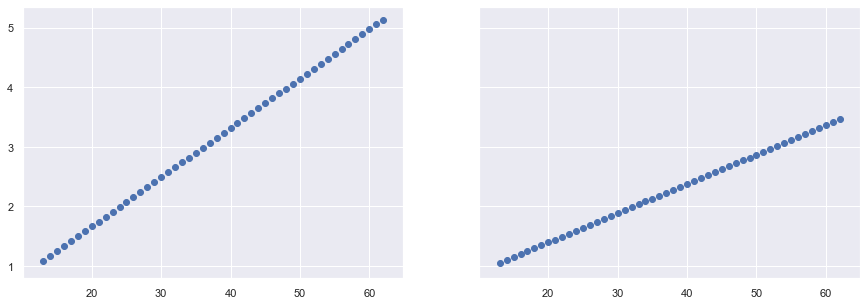

In [41]:
coef, coef_p = vary_y(X, y, X_p, y_p, 50, (12,13))
plot_dbl_graph(coef, coef_p)

In [42]:
fit_coef(coef, coef_p)

[[0.08291881]] 0.9999956987027289
[[0.05869959]] 0.3360284419982993


In [43]:
## So as soon as you know 2 pts with same x, you know how the others will vary?

In [44]:
## need a way to fit curve to coef, then maybe can get as a function of x and y if there
## is no interaction term

(<Figure size 1080x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1dc50210>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1dd79e50>))

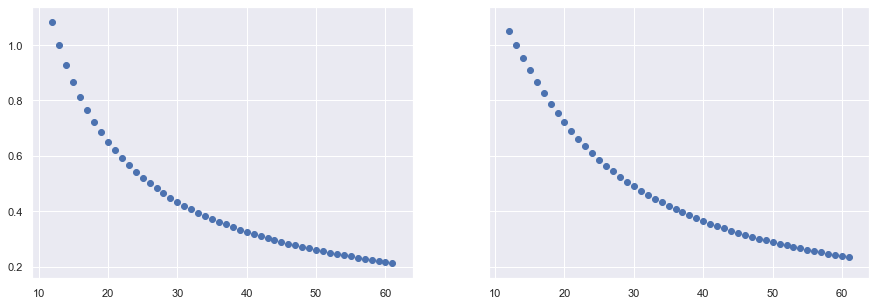

In [45]:
coef, coef_p = vary_x(X, y, X_p, y_p, 50, (12,13))
plot_dbl_graph(coef, coef_p)

In [46]:
coef = apply_transform(coef, lambda x: 1/x)
coef_p = apply_transform(coef_p, lambda x: 1/x)

(<Figure size 1080x360 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a1de14b10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a1d7b7750>))

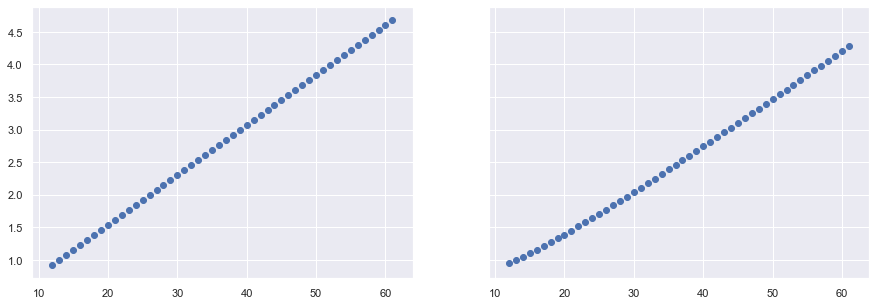

In [47]:
plot_dbl_graph(coef, coef_p)

In [48]:
fit_coef(coef, coef_p)

[0.07683298] 0.9999997583647741
[0.0692833] 0.9285907002762018


In [49]:
# vary the pt along the line and see how a given pt changes the model?

## yeah...

In [50]:
# so want to know how many pts will uniquely identify the model
# so create a dataset and then take a given pt and add on

In [51]:
def create_dataset(pts):
    try:
        d = len(pts[0]) - 1
        n = len(pts)
        X = pts[:,:-1]
        y = pts[:,-1:]
    except:
        d = len(pts) - 1
        n = 1
        X = pts[:-1].reshape(n,d)
        y = pts[-1].reshape(n,1)
    return(X,y)

In [52]:
# first dataset / motivating example

In [53]:
pts = np.array([[1,1]])
X, y = create_dataset(pts)

In [54]:
ex_X, ex_y = extend_ds_single(X, y, (10, 15))

In [55]:
lm_original = LinearRegression(fit_intercept=False)
lm_extended = LinearRegression(fit_intercept=False)
lm_original.fit(X, y)
lm_extended.fit(ex_X, ex_y)
print(lm_original.coef_)
print(lm_extended.coef_)

[[1.]]
[[1.4950495]]


In [56]:
# Question: could it have been any other pt that created this original dataset?

we could imagine running through a random number of datasets to find a linear model that has this coefficient, but that seems unreasonable. Instead, we should work on finding an example where a single point does not work, and then go down to the lower case below where we have two points. If we have two points, then we potentially learn something about the size of the dataset or something else, that essentially allows us to figure out what our initial point would have been. So first, an example showing that our current coefficient could have been created by some other dataset. A contrived example. Obviously, it could have been created by two points where 1.495 is the mean! So one point is definitely not enough. Buuuut... if you know that your dataset was only one point, then that might be a different story. If we knew it was one point, could we create some function, or use some additional information that we construct right now that would tell us what our initial point was? What exact info is our second point really giving us?

What if we have different datasets: 
1,1
1,1 2,2
1,1 2,2 3,3 and so on, and we see how an additional point affects? Could be a bit harder and not entirely sure what I'd gain from it. 

In [57]:
coef_extended = []
for i in range(100):
    pts = np.array([[i,i]])
    X, y = create_dataset(pts)
    ex_X, ex_y = extend_ds_single(X, y, (100, 150))
    lm_original = LinearRegression(fit_intercept=False)
    lm_extended = LinearRegression(fit_intercept=False)
    lm_original.fit(X, y)
    lm_extended.fit(ex_X, ex_y)
    coef_extended.append(lm_extended.coef_[0])
coef_extended = np.asarray(coef_extended)

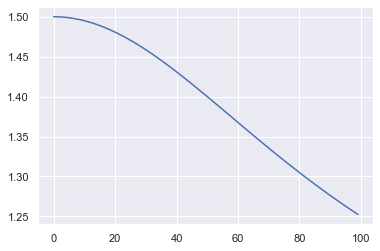

In [58]:
plt.plot([i for i in range(100)], coef_extended)

In [59]:
coef_extended

array([[1.5       ],
       [1.49995   ],
       [1.49980008],
       [1.4995504 ],
       [1.49920128],
       [1.49875312],
       [1.49820646],
       [1.49756195],
       [1.49682035],
       [1.49598254],
       [1.4950495 ],
       [1.49402233],
       [1.49290221],
       [1.49169043],
       [1.49038839],
       [1.48899756],
       [1.4875195 ],
       [1.48595588],
       [1.48430841],
       [1.4825789 ],
       [1.48076923],
       [1.47888133],
       [1.47691721],
       [1.47487891],
       [1.47276853],
       [1.47058824],
       [1.4683402 ],
       [1.46602666],
       [1.46364985],
       [1.46121207],
       [1.4587156 ],
       [1.45616276],
       [1.45355588],
       [1.45089729],
       [1.44818932],
       [1.4454343 ],
       [1.44263456],
       [1.43979242],
       [1.43691017],
       [1.43399011],
       [1.43103448],
       [1.42804554],
       [1.4250255 ],
       [1.42197654],
       [1.4189008 ],
       [1.41580042],
       [1.41267745],
       [1.409

# ok i know this has been weird and not v focused, but let's try the one pt above one pt below tactic

In [60]:
pts = np.array([[1,1]])
X, y = create_dataset(pts)

In [61]:
ab_X, ab_y = extend_ds_single(X, y, (10, 15))
bl_X, bl_y = extend_ds_single(ab_X, ab_y, (10, 10))

In [62]:
lm_original = LinearRegression(fit_intercept=False)
lm_above = LinearRegression(fit_intercept=False)
lm_below = LinearRegression(fit_intercept=False)
lm_original.fit(X, y)
lm_above.fit(ab_X, ab_y)
lm_below.fit(bl_X, bl_y)
print(lm_original.coef_)
print(lm_above.coef_)
print(lm_below.coef_)

[[1.]]
[[1.4950495]]
[[1.24875622]]
